In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [9]:
# Define the ticker symbols for assets in the portfolio
ticker_symbols = ['AAPL', 'GOOG', 'MSFT', 'TSLA']

# Fetch historical stock data using yfinance
stock_data = yf.download(ticker_symbols, start='2020-01-01', end='2024-03-31')

# Calculate daily returns for each asset
daily_returns = stock_data['Adj Close'].pct_change().dropna()


[*********************100%%**********************]  4 of 4 completed


In [10]:
# Calculate mean returns and covariance matrix
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Number of assets
num_assets = len(ticker_symbols)

# Define risk-free rate (e.g., 10-year Treasury yield)
risk_free_rate = 0.04 # Example risk-free rate as decimal

In [14]:
mean_returns

AAPL    0.001012
GOOG    0.000966
MSFT    0.001145
TSLA    0.002602
dtype: float64

In [11]:
# Objective function to minimize portfolio variance
def portfolio_variance(weights):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Constraint function for portfolio expected return
def portfolio_return_constraint(weights, target_return):
    return np.sum(mean_returns * weights) - target_return

# Calculate minimum variance frontier
min_variance_frontier = []
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), num=50)
for target_return in target_returns:
    # Initial guess for portfolio weights
    initial_weights = np.ones(num_assets) / num_assets
    constraints = ({'type': 'eq', 'fun': portfolio_return_constraint, 'args': (target_return,)},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    min_variance_frontier.append((np.sqrt(result.fun), target_return))


In [12]:
# Convert to DataFrame for easier manipulation
min_variance_frontier_df = pd.DataFrame(min_variance_frontier, columns=['Standard Deviation', 'Return'])


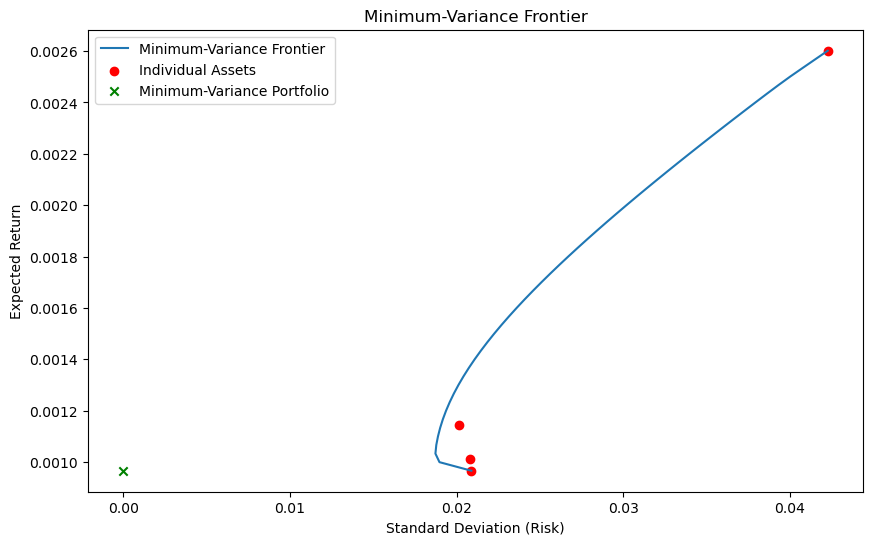

In [13]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the minimum-variance frontier
ax.plot(min_variance_frontier_df['Standard Deviation'], min_variance_frontier_df['Return'], label='Minimum-Variance Frontier')

# Plot individual assets
ax.scatter(np.sqrt(np.diag(cov_matrix)), mean_returns, marker='o', color='red', label='Individual Assets')

# Plot optimal portfolio (minimum variance)
ax.scatter(0, mean_returns.min(), marker='x', color='green', label='Minimum-Variance Portfolio')

# Set labels and title
ax.set_xlabel('Standard Deviation (Risk)')
ax.set_ylabel('Expected Return')
ax.set_title('Minimum-Variance Frontier')

# Add legend
ax.legend()

plt.show()